In [150]:
%matplotlib inline
from matplotlib import pyplot as plt
import velocyto as vcy
import loompy
import anndata
import numpy as np
import scanpy.api as sc
import scipy.io
import pandas as pd

sc.settings.set_figure_params(dpi=100)

### Creating a loom object/file with loompy:
A loom object has three components
* Data matrix, either numpy ndarray or scipy sparse matrix
* Dictionary of row attributes
* Dictionary of column attributes

If the data matrix is a N row x M col matrix, the row attribute dict must have M elements and the column attribute dict must have N elements.

In [4]:
#load mdsc.combined counts matrix:
input_dir = '/Users/samuelmorabito/Documents/kessenbrock_rotation/Doublet_Pipelines_Data/MDSCs/filtered_gene_bc_matrices_mex/mm10/'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
barcodes = np.array([line[:-1] for line in open(input_dir + '/barcodes.tsv')])
genes = np.array([line.split()[1] for line in open(input_dir + "/genes.tsv")])

In [28]:
#separate into wt and pymt:
#wt
wt_barcodes = np.array([b for b in barcodes if b.endswith("-1")])
wt_filter = np.ravel(np.array([True if b.endswith("-1") else False for b in barcodes]))
wt_counts_matrix = counts_matrix[wt_filter]
wt_row_attributes = {"barcode": wt_barcodes}

#pymt
pymt_barcodes = np.array([b for b in barcodes if b.endswith("-2")])
pymt_filter = np.ravel(np.array([True if b.endswith("-2") else False for b in barcodes]))
pymt_counts_matrix = counts_matrix[pymt_filter]
pymt_row_attributes = {"barcode": pymt_barcodes}
col_attributes = {"genes": genes}

#create loom objects for wt and pymt
loompy.create(
    "/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/loom_files/mdsc_wt.loom",
    wt_counts_matrix,
    wt_row_attributes,
    col_attributes
)
loompy.create(
    "/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/loom_files//mdsc_pymt.loom",
    pymt_counts_matrix,
    pymt_row_attributes,
    col_attributes
)

Some notes about creating loom files:

* `loompy.create()` does not return anything. To work with the .loom file, you need to use `loompy.connect("file.loom")`. 
* The [loompy documentation](https://linnarssonlab.org/loompy/apiwalkthrough/index.html) recommends using something like `with loom.connect("file.loom") as ds:`. Alternatively, if you do something like `ds = loom.connect("file.loom")` you also need something like `ds.close()` to close the connection to the loom file.
* Instead of `loompy.create()` you can use `loompy.new()` to create and connect simultaneously.

In [6]:
wt_loom = loompy.connect("/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/loom_files/mdsc_wt.loom")
pymt_loom = loompy.connect("/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/loom_files/mdsc_pymt.loom")

In [7]:
wt_loom.close()
pymt_loom.close()

In [3]:
vlm = vcy.VelocytoLoom("../velocyto/SCG71.loom")

In [ ]:
#load raw counts matrix, genes list, and barcodes
input_dir = '/Users/samuelmorabito/Documents/kessenbrock_rotation/MDSCs/filtered_gene_bc_matrices_mex/mm10/'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))
barcodes = np.array(scr.load_genes(input_dir + 'barcodes.tsv', delimiter='t', column=0))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

### Processing ind5
1. Isolate ind5 entries.
2. Exclude genes that appear in less than 3 cells. Exclude cells that have less than 500 genes.
3. Compute percentage of mitochondrial genes for each cell.
4. Exclude cells with percent.mito >= 0.1. Exclude cells with more than 6000 genes.
5. Log normalize data.
6. Find highly variable genes
7. Scale data, regress nUMI and percent.mito
8. Run PCA. PCA elbow plot
9. Run tSNE
10. Find clusters
11. Make feature plots
12. Marker genes

In [122]:
ind5 = sc.read_10x_mtx(
    "/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/ind_5_6_7_aggr/filtered_gene_bc_matrices_mex/GRCh38/",
    var_names = "gene_symbols",
    cache=True
)

In [123]:
# 1. isolate ind5 entries:
ind5 = ind5[[True if "-1" in item else False for item in ind5.obs.T]]

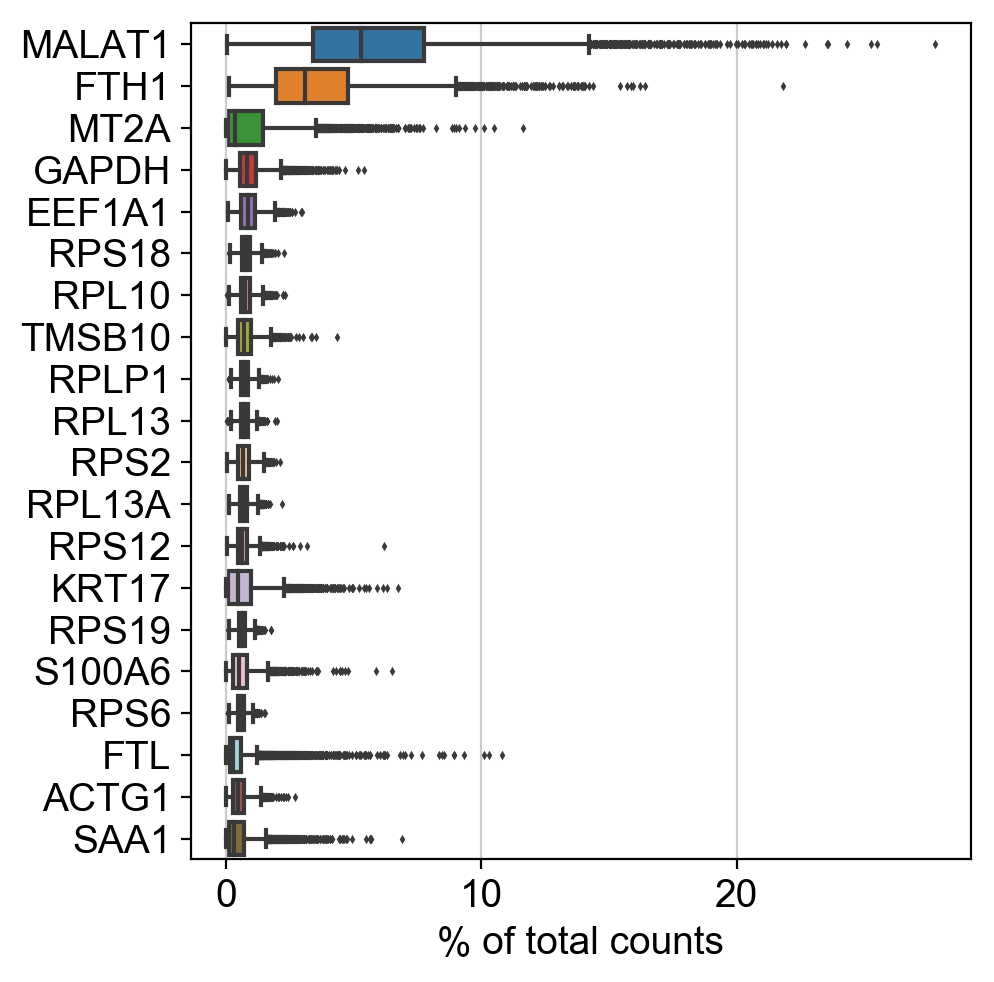

In [124]:
# plot highest expressed genes:
sc.pl.highest_expr_genes(ind5, n_top=20)

In [125]:
# 2. Exclude genes that appear in less than 3 cells. Exclude cells that have less than 500 genes.
sc.pp.filter_cells(ind5, min_genes=500)
sc.pp.filter_genes(ind5, min_cells=3)

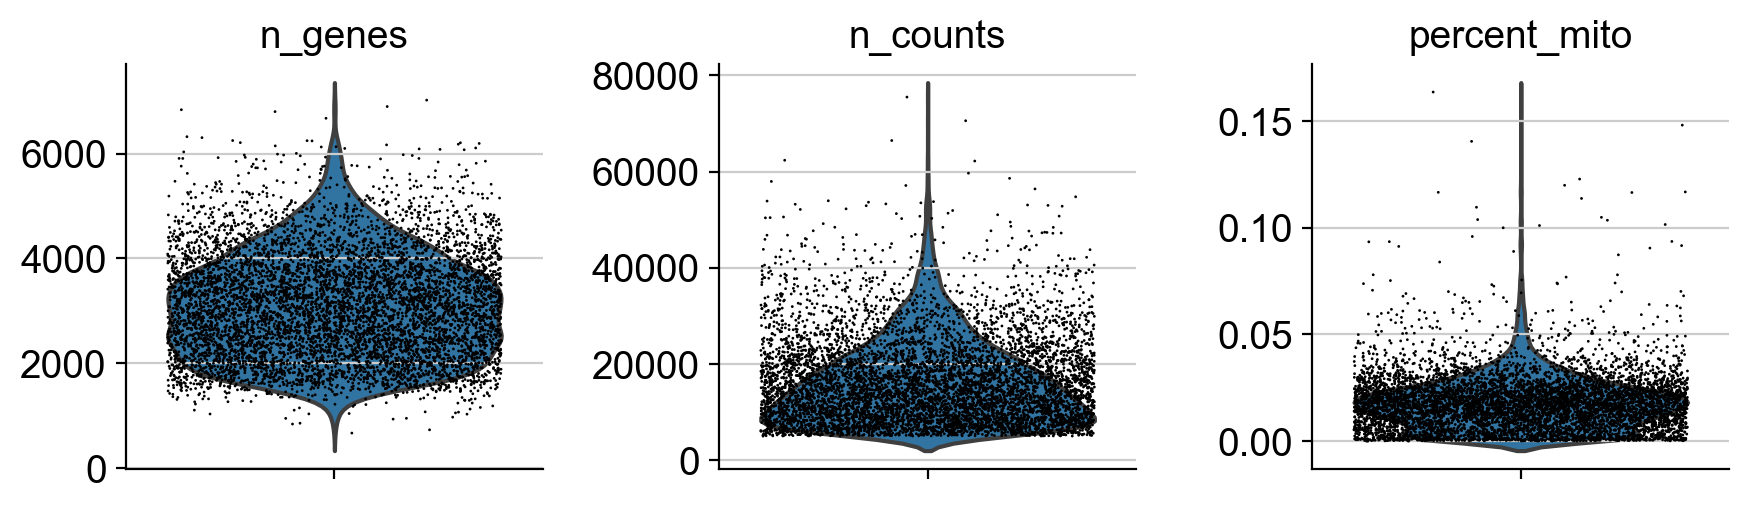

In [126]:
# 3. Compute percentage of mitochondrial genes in each cell
mito_genes = [name for name in ind5.var_names if name.startswith("MT-")]

#compute fraction of counts in mito genes vs all genes for each cell
ind5.obs['percent_mito'] = np.sum(ind5[:, mito_genes].X, axis=1).A1 / np.sum(ind5.X, axis=1).A1
ind5.obs['n_counts'] = ind5.X.sum(axis=1).A1
sc.pl.violin(ind5, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

In [127]:
# 4. exclude cells with more than 6000 genes and cels with percento_mito > 0.1
ind5 = ind5[ind5.obs.n_genes < 6000, :]
ind5 = ind5[ind5.obs.percent_mito < 0.1, :]

In [128]:
# 5. log transform data:
ind5.raw = sc.pp.log1p(ind5, copy=True)
sc.pp.log1p(ind5)

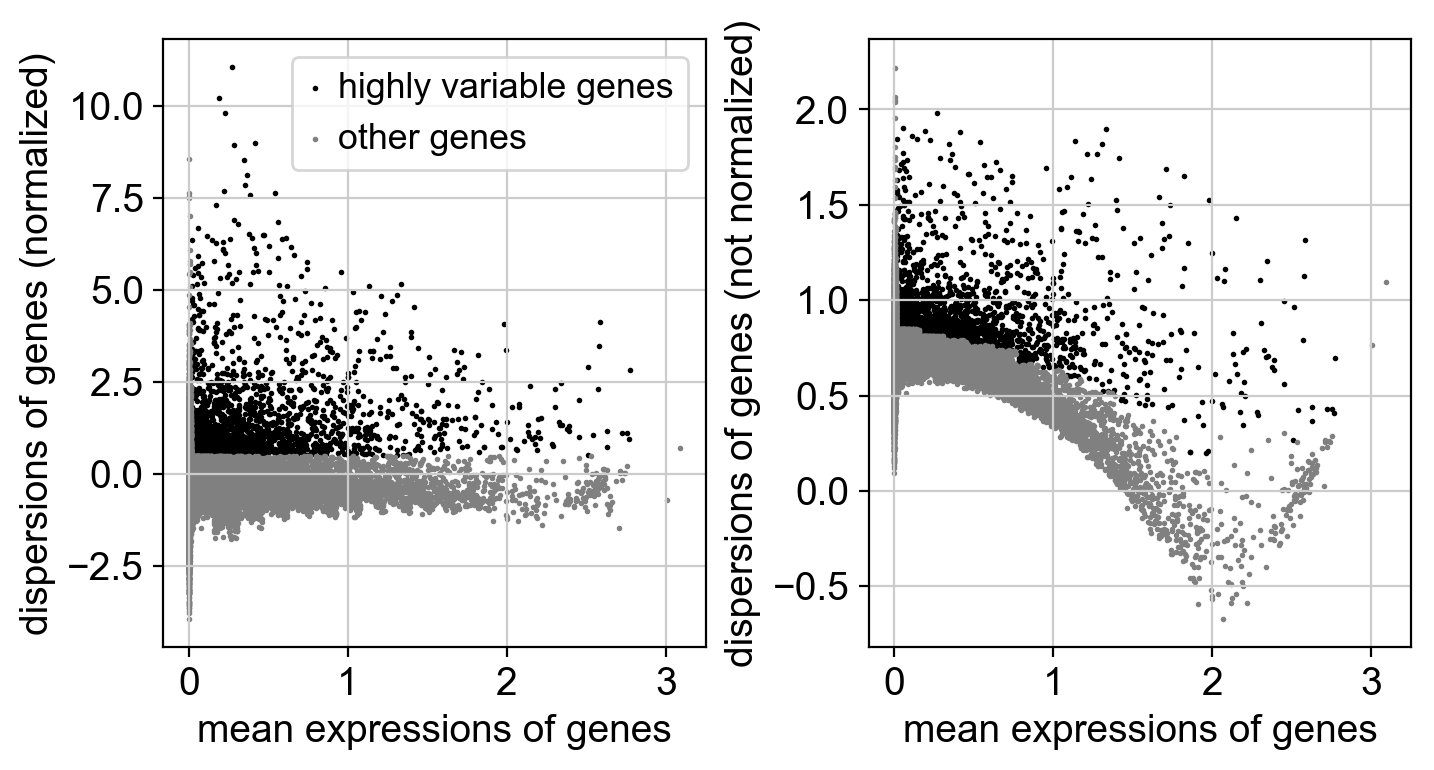

In [131]:
# 6. Find highly variable genes:
sc.pp.normalize_per_cell(ind5, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(ind5.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [134]:
# filter out highly variable genes:
ind5 = ind5[:, filter_result.gene_subset]
sc.pp.log1p(ind5)

In [136]:
# 7. Regress out n_counts and percent_mito and scale data:
sc.pp.regress_out(ind5, ['n_counts', 'percent_mito'])
sc.pp.scale(ind5,max_value=10)

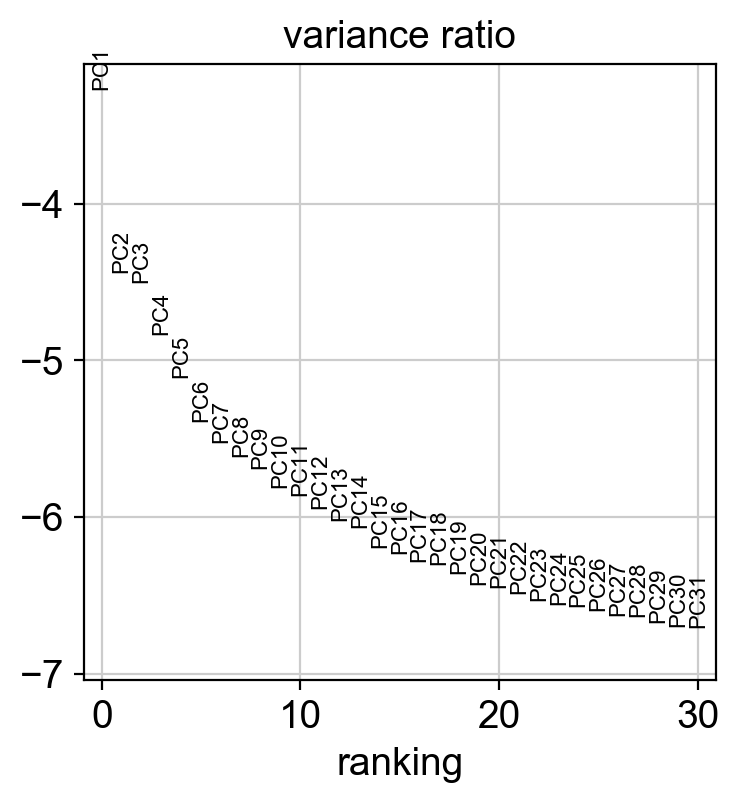

In [139]:
# 8. Run PCA:
sc.tl.pca(ind5, svd_solver='arpack')
sc.pl.pca_variance_ratio(ind5, log=True)

In [141]:
sc.pp.neighbors(ind5)

In [142]:
sc.tl.tsne(ind5)

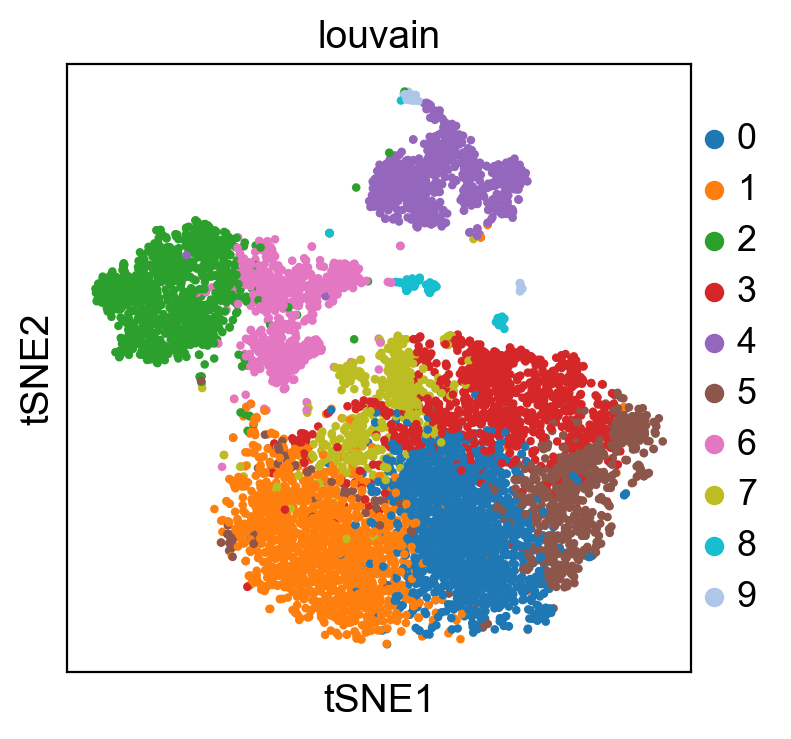

In [179]:
sc.pl.tsne(ind5, color='louvain')

In [183]:
#save as anndata and as loom:
ind5.write("/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/ind5.h5ad")
#ind5.write_loom("/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/ind5.loom")

In [177]:
? ind5.write_loom

In [145]:
# clustering:
sc.tl.louvain(ind5)

saving figure to file ./figures/rank_genes_groups_louvain.pdf


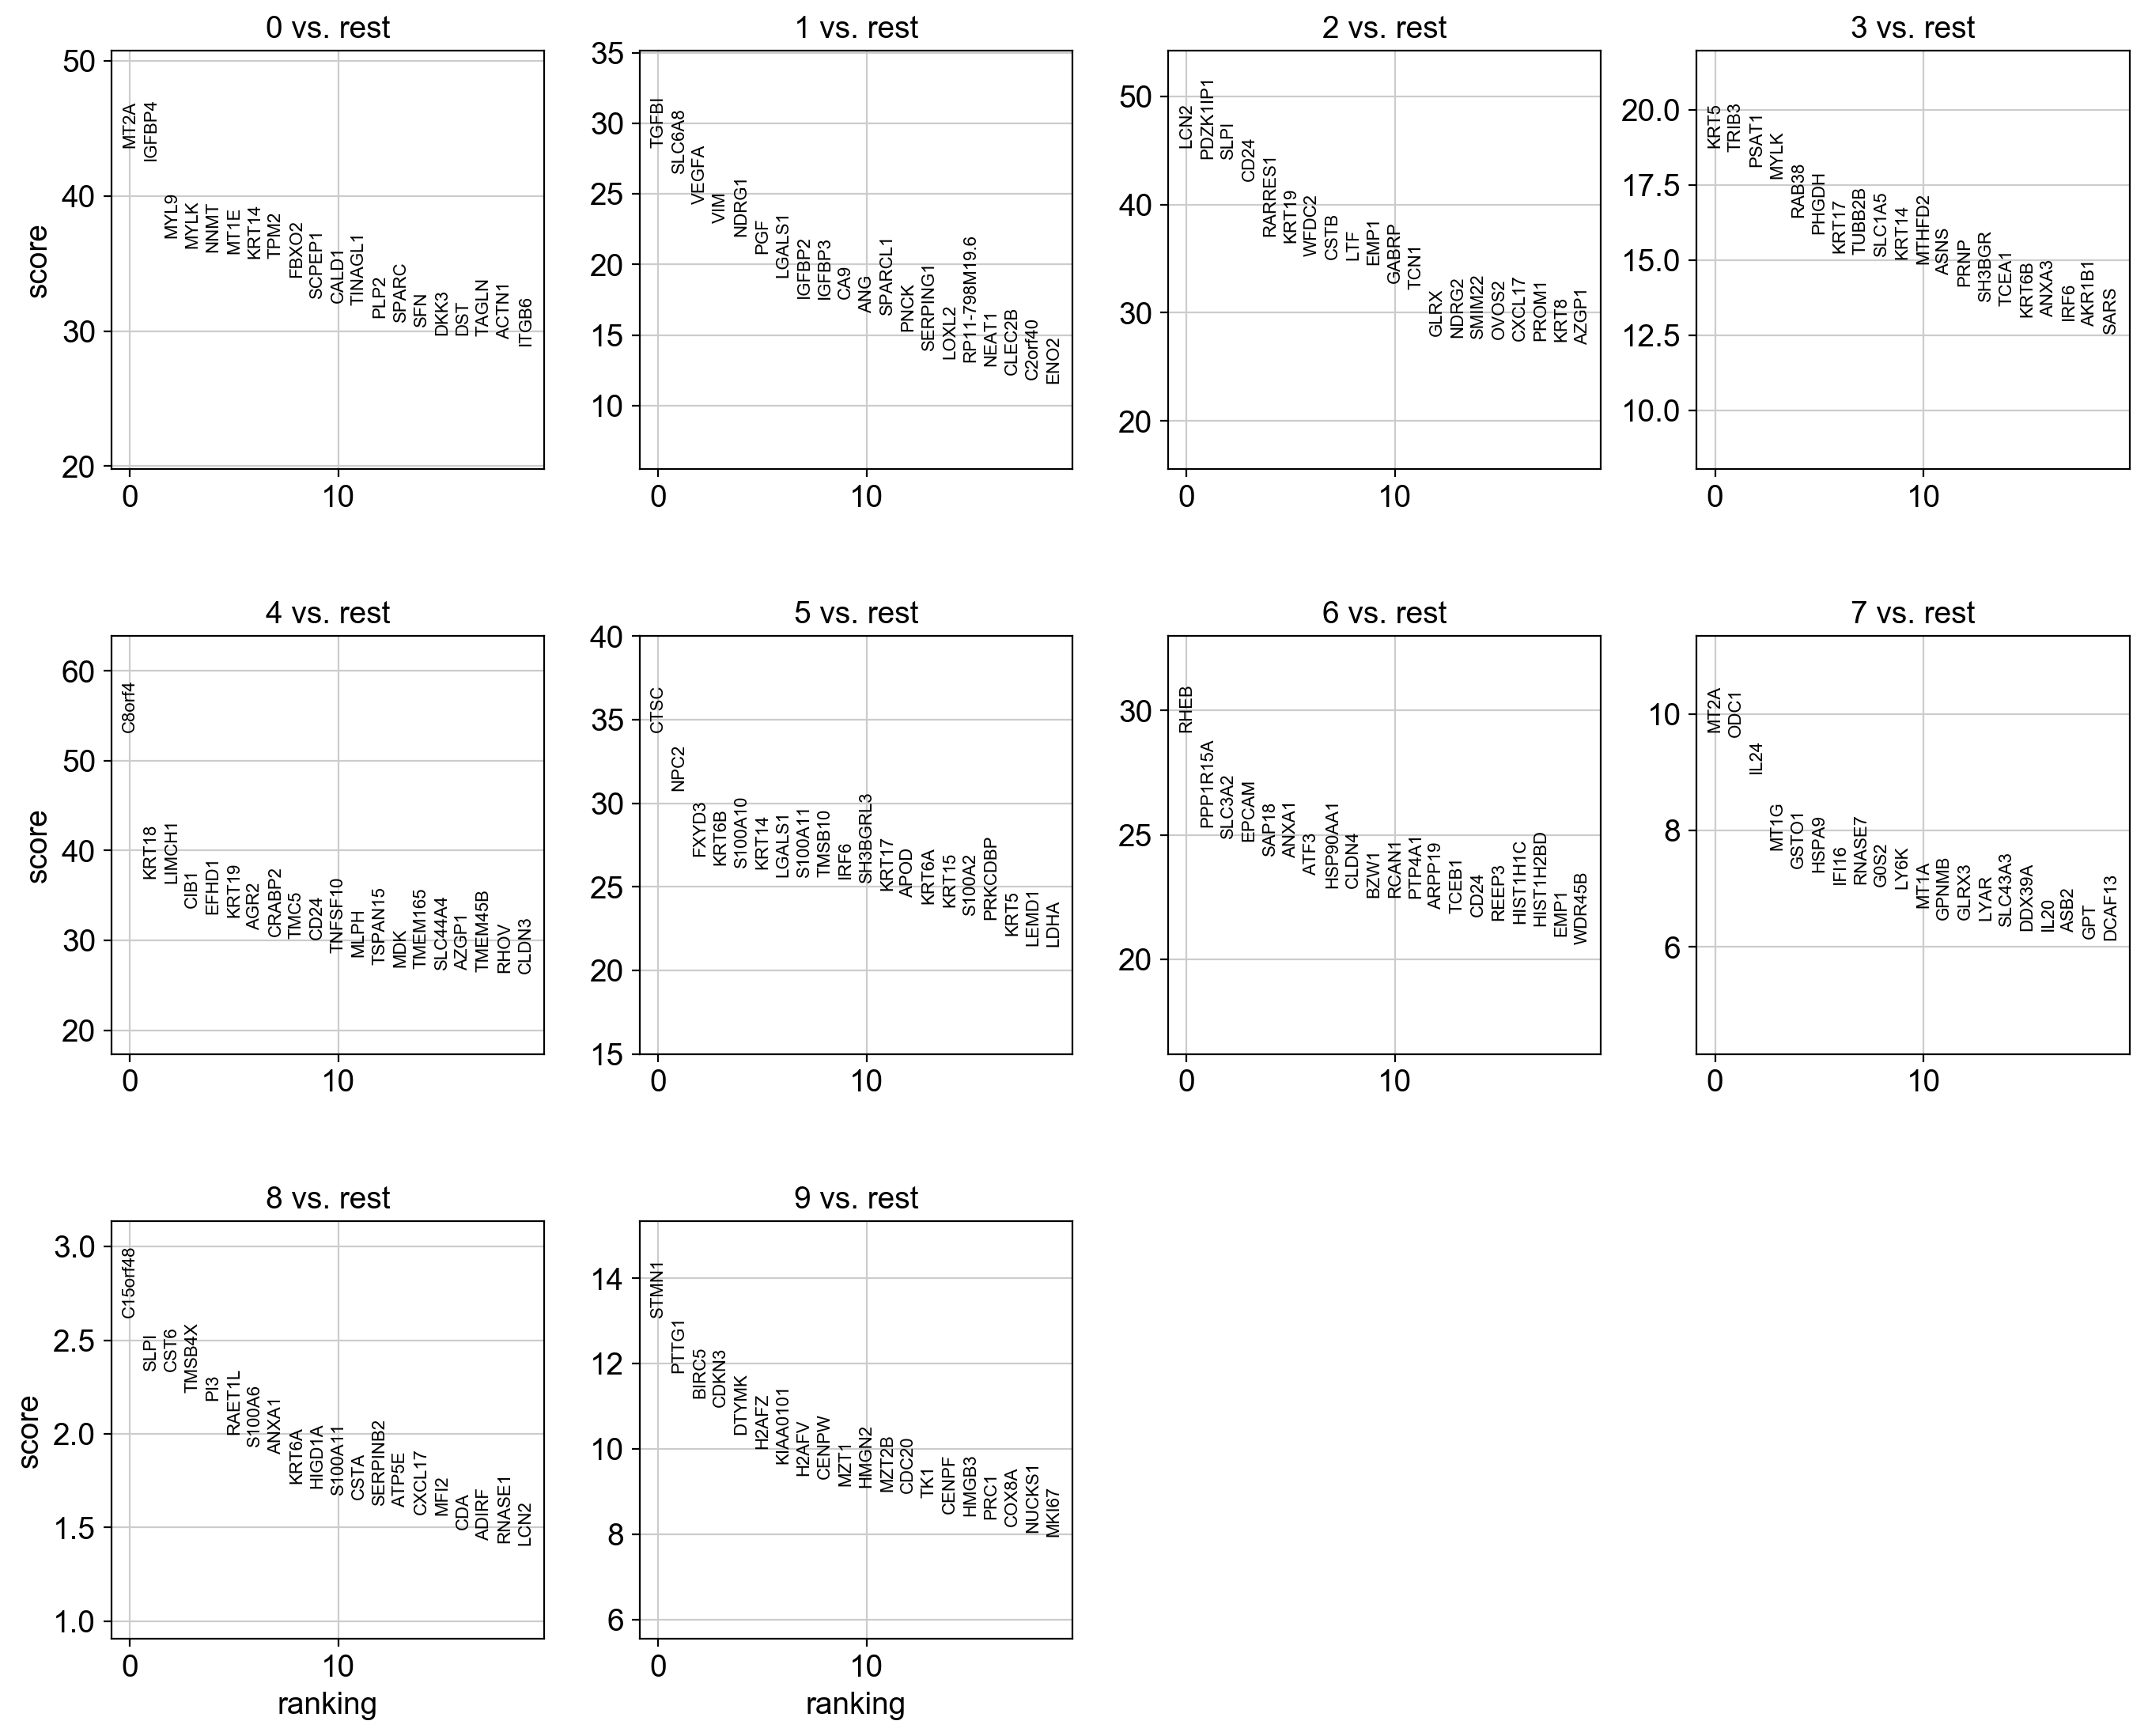

In [147]:
# find marker genes:
sc.tl.rank_genes_groups(ind5, 'louvain')
sc.pl.rank_genes_groups(ind5, n_genes=20, sharey=False, save=".pdf")

In [166]:
pd.DataFrame(ind5.uns['rank_genes_groups']['names']).head(5)

#define marker genes as the 
marker_genes = list(ind5.uns['rank_genes_groups']['names'][0])

In [152]:
result = ind5.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s,7_n,7_s,8_n,8_s,9_n,9_s
0,MT2A,43.590477,TGFBI,28.293276,LCN2,45.276737,KRT5,18.747400,C8orf4,53.149540,CTSC,34.239025,RHEB,29.119608,MT2A,9.684330,C15orf48,2.620862,STMN1,13.079678
1,IGFBP4,42.601971,SLC6A8,26.476011,PDZK1IP1,44.237263,TRIB3,18.616234,KRT18,36.858997,NPC2,30.772760,PPP1R15A,25.327532,ODC1,9.610183,SLPI,2.339110,PTTG1,11.778135
2,MYL9,36.868015,VEGFA,24.287170,SLPI,44.219818,PSAT1,18.100342,LIMCH1,36.396240,FXYD3,26.824694,SLC3A2,24.863295,IL24,8.986981,CST6,2.335835,BIRC5,11.197762
3,MYLK,36.117550,VIM,22.931015,CD24,42.204235,MYLK,17.708220,CIB1,33.595123,KRT6B,26.293037,EPCAM,24.754814,MT1G,7.659148,TMSB4X,2.219742,CDKN3,10.993849
4,NNMT,35.847340,NDRG1,22.000366,RARRES1,37.085922,RAB38,16.429844,EFHD1,32.956566,S100A10,26.168829,SAP18,24.184122,GSTO1,7.356843,PI3,2.178677,DTYMK,10.336716


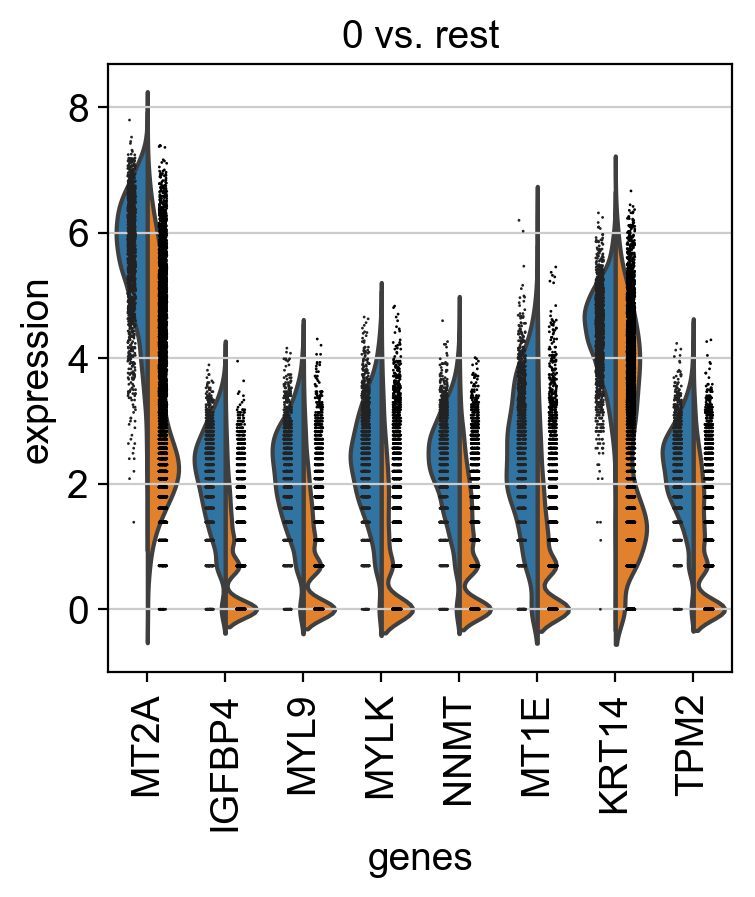

In [156]:
sc.pl.rank_genes_groups_violin(ind5, groups='0', n_genes=8)


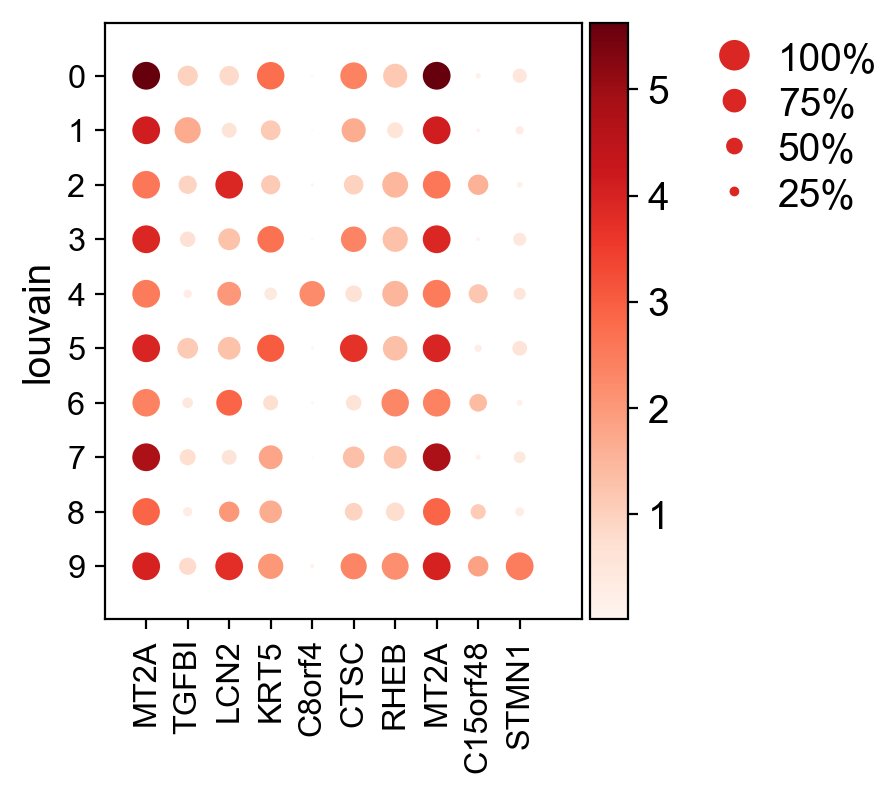

GridSpec(2, 4, height_ratios=[0, 10.5], width_ratios=[5.0, 0.4, 0.7, 0.5])

In [167]:
sc.pl.dotplot(ind5, marker_genes, groupby='louvain')

saving figure to file ./figures/stacked_violin.pdf


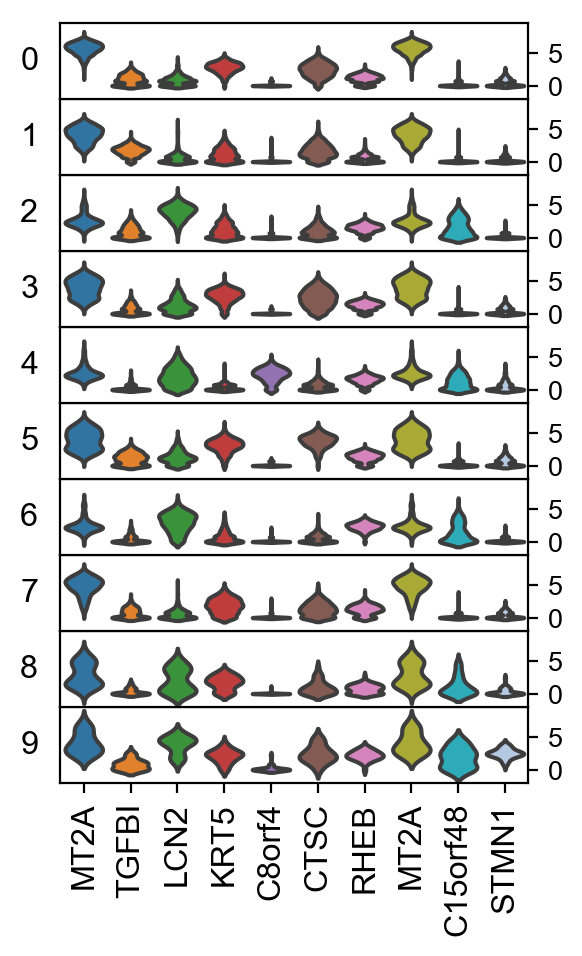

GridSpec(10, 1)

In [168]:
sc.pl.stacked_violin(ind5, marker_genes, groupby='louvain', rotation=90, save='.pdf')